# Taxi Price Prediction - Data Processing and Modeling

## Introduction
This notebook walks through the process of analyzing and predicting taxi trip prices using machine learning models. Each section is explained step by step to make it easy to understand. The goal is to clean, preprocess, and train various models to find the best one for accurate price prediction.

## 1. Import Necessary Libraries
Before we begin, we need to import all the required libraries. These libraries help us handle data, visualize patterns, and build machine learning models.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
import joblib
import missingno as msno
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## 2. Download and Load the Dataset
We fetch the latest dataset from Kaggle and load it into a Pandas DataFrame.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("denkuznetz/taxi-price-prediction")
print("Path to dataset files:", path)

# Get the list of files in the downloaded directory
files = os.listdir(path)

# Find the CSV file and load it
csv_file = [f for f in files if f.endswith('.csv')][0]
csv_file_path = os.path.join(path, csv_file)
df = pd.read_csv(csv_file_path)

100%|██████████| 19.6k/19.6k [00:00<00:00, 6.19MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/denkuznetz/taxi-price-prediction/versions/1


## 3. Explore and Understand the Dataset
It's essential to check the structure of the dataset before processing it. We look at the first few rows, column types, and check for missing values.

In [ ]:
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [ ]:
df['Weather'].unique()

array(['Clear', nan, 'Rain', 'Snow'], dtype=object)

In [ ]:
df.shape

(1000, 11)

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB
None


In [ ]:
df.describe()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,951.000000
mean,27.070547,2.476842,3.502989,1.233316,0.292916,62.118116,56.874773
std,19.905300,1.102249,0.870162,0.429816,0.115592,32.154406,40.469791
min,1.230000,1.000000,2.010000,0.500000,0.100000,5.010000,6.126900
25%,12.632500,1.250000,2.730000,0.860000,0.190000,35.882500,33.742650
50%,25.830000,2.000000,3.520000,1.220000,0.290000,61.860000,50.074500
75%,38.405000,3.000000,4.260000,1.610000,0.390000,89.055000,69.099350
max,146.067047,4.000000,5.000000,2.000000,0.500000,119.840000,332.043689


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

,0
Trip_Distance_km,50
Time_of_Day,50
Day_of_Week,50
Passenger_Count,50
Traffic_Conditions,50
Weather,50
Base_Fare,50
Per_Km_Rate,50
Per_Minute_Rate,50
Trip_Duration_Minutes,50


## 4. Handle Missing Data
Missing data can affect our model's performance. We analyze and fill missing values using median values for numerical columns and mode for categorical columns.

In [ ]:
# Percentage of missing values per column
missing_percentage = df.isnull().sum() / len(df) * 100
missing_percentage

,0
Trip_Distance_km,5.0
Time_of_Day,5.0
Day_of_Week,5.0
Passenger_Count,5.0
Traffic_Conditions,5.0
Weather,5.0
Base_Fare,5.0
Per_Km_Rate,5.0
Per_Minute_Rate,5.0
Trip_Duration_Minutes,5.0


<Axes: >

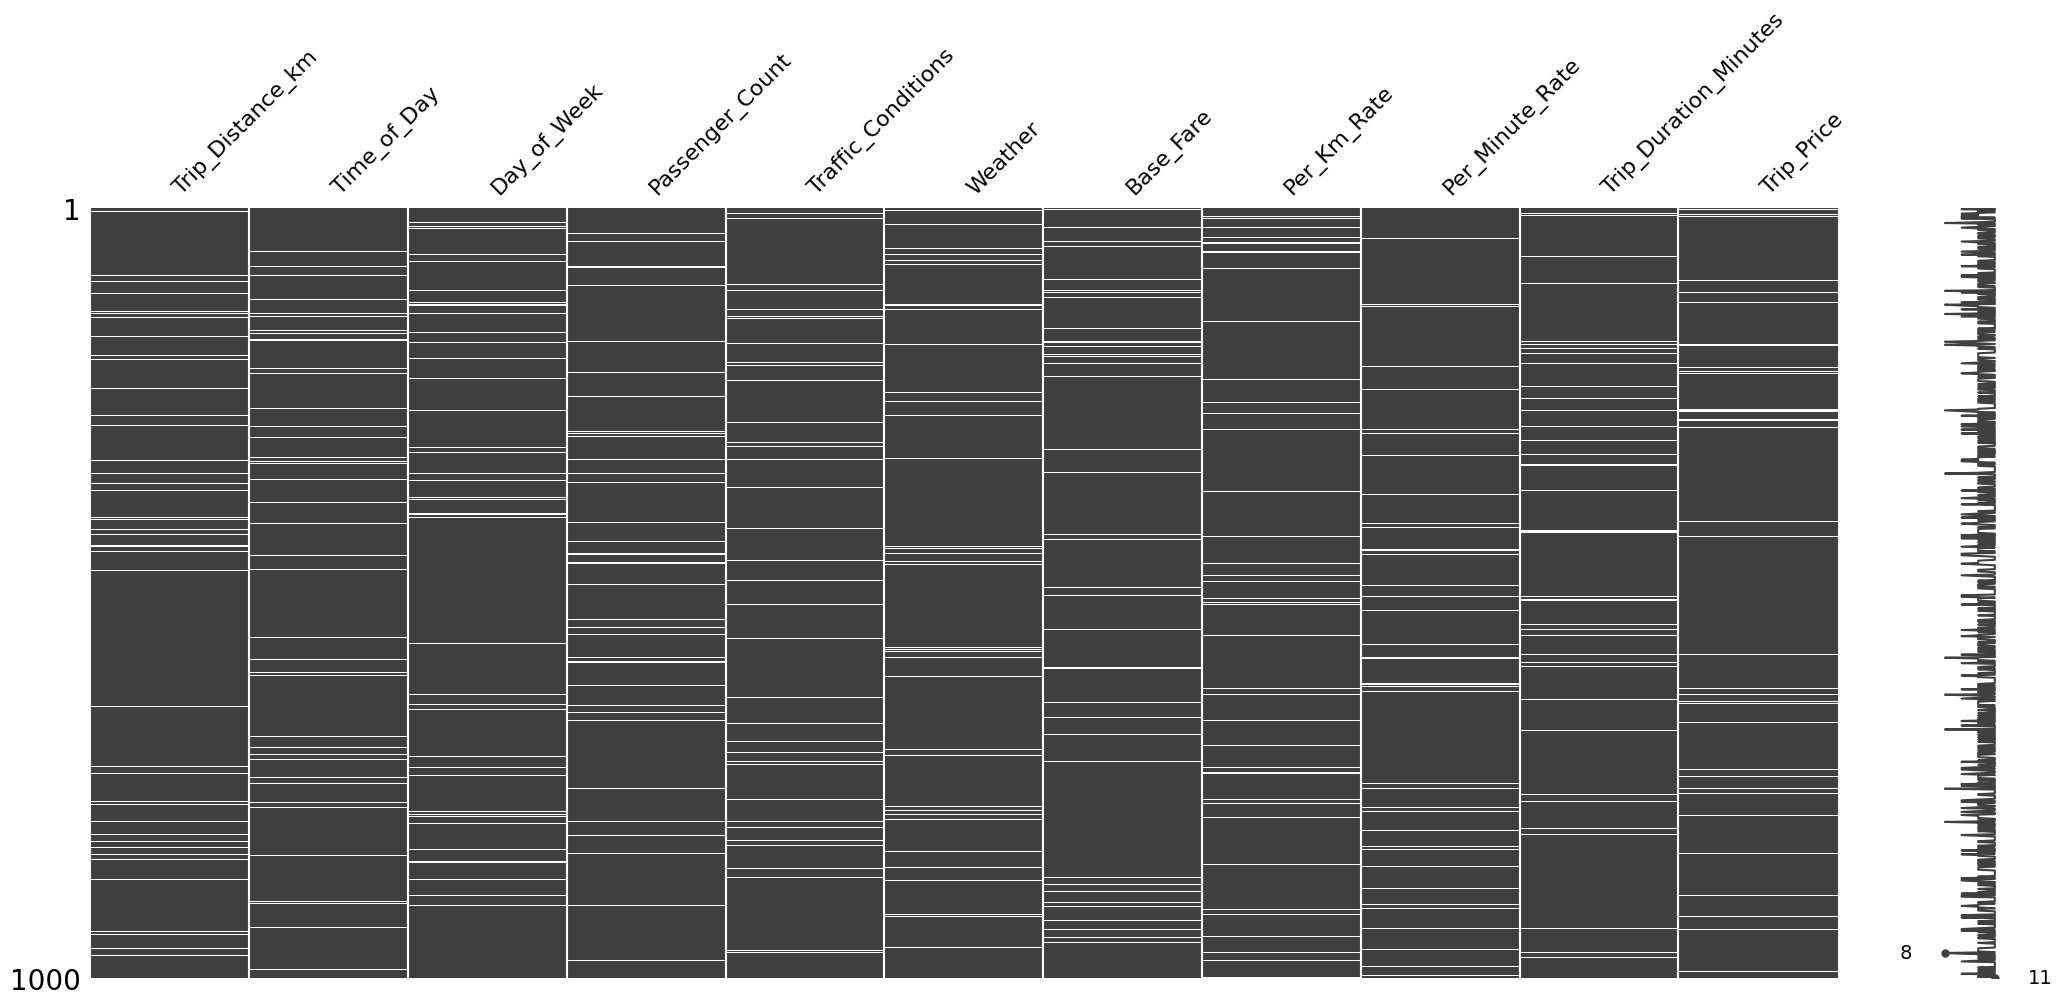

In [ ]:
# Visualizing missing data
msno.matrix(df)

In [ ]:
columns_miss = df.columns[df.isnull().sum() > 0]

df[columns_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


Trip_Distance_km - Mean: 27.070546861761322, Median: 25.83


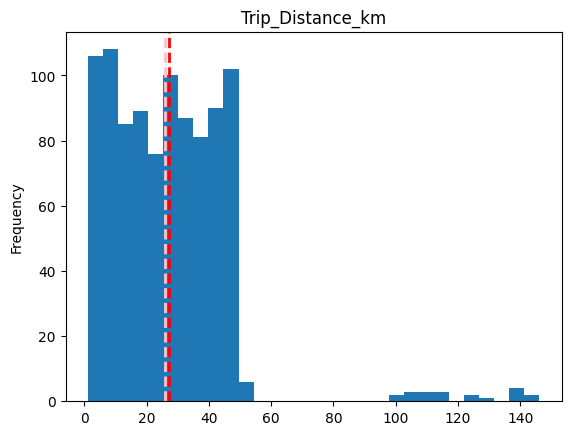

Passenger_Count - Mean: 2.4768421052631577, Median: 2.0


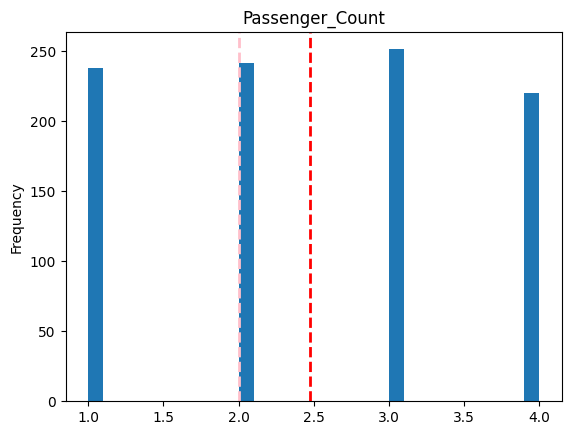

Base_Fare - Mean: 3.502989473684211, Median: 3.52


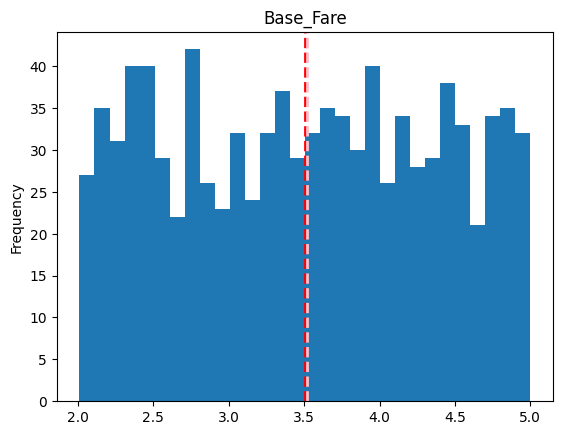

Per_Km_Rate - Mean: 1.2333157894736844, Median: 1.22


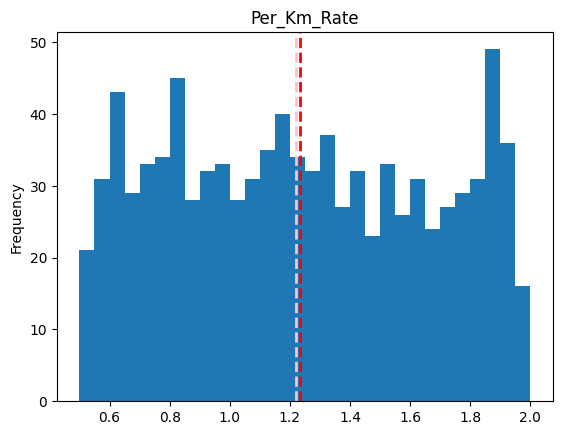

Per_Minute_Rate - Mean: 0.2929157894736842, Median: 0.29


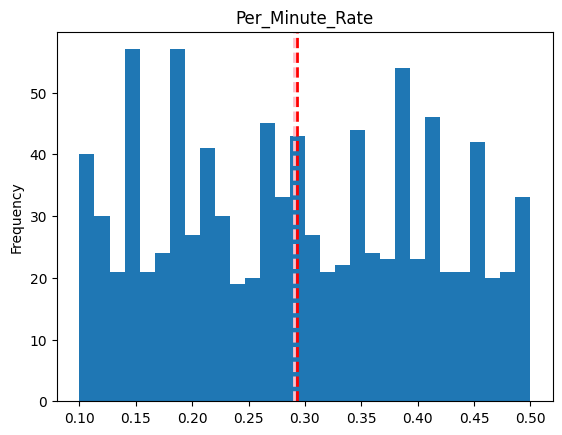

Trip_Duration_Minutes - Mean: 62.11811578947369, Median: 61.86


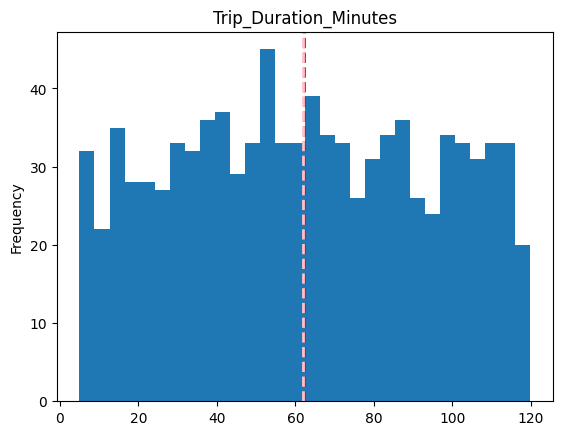

Trip_Price - Mean: 56.87477332571041, Median: 50.07450000000001


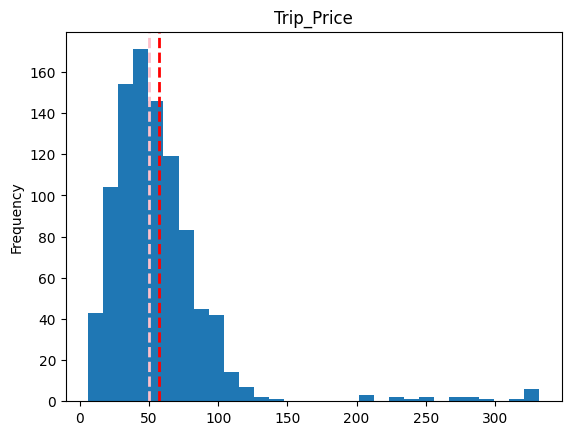

In [ ]:
for i in df.select_dtypes(include=[np.number]):
    print(f"{i} - Mean: {df[i].mean()}, Median: {df[i].median()}")
    df[i].plot(kind='hist', bins=30, title=i)
    plt.axvline(df[i].mean(), color='red', linestyle='dashed', linewidth=2)
    plt.axvline(df[i].median(), color='pink', linestyle='dashed', linewidth=2)
    plt.show()

In [ ]:
# Filling missing values
for col in df.select_dtypes(include=[np.number]):
    df[col].fillna(df[col].median(), inplace=True)

In [ ]:
columns_miss = df.columns[df.isnull().sum() > 0]

df[columns_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Time_of_Day         950 non-null    object
 1   Day_of_Week         950 non-null    object
 2   Traffic_Conditions  950 non-null    object
 3   Weather             950 non-null    object
dtypes: object(4)
memory usage: 31.4+ KB


In [ ]:
# Filling categorical missing values
for col in df.select_dtypes(include=['object']):
    df[col] = df[col].fillna(df[col].mode()[0])

In [ ]:
# Percentage of missing values per column
missing_percentage = df.isnull().sum() / len(df) * 100
missing_percentage

,0
Trip_Distance_km,0.0
Time_of_Day,0.0
Day_of_Week,0.0
Passenger_Count,0.0
Traffic_Conditions,0.0
Weather,0.0
Base_Fare,0.0
Per_Km_Rate,0.0
Per_Minute_Rate,0.0
Trip_Duration_Minutes,0.0


## 5. Remove Outliers
Outliers can distort the model's predictions. We use the Z-score method to remove rows with extreme values.

In [ ]:
# Step 2: Remove outliers using Z-score
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))  # Only numeric columns
df_clean = df[(z_scores < 3).all(axis=1)]  # Remove rows where Z-score > 3 or < -3

print(f"Dataset size before outlier removal: {df.shape}")
print(f"Dataset size after outlier removal: {df_clean.shape}")

Dataset size before outlier removal: (1000, 11)
Dataset size after outlier removal: (980, 11)


## 6. Convert Categorical Features into Numerical
Machine learning models require numerical input. We use one-hot encoding for categorical variables.

In [ ]:
# One-Hot Encoding categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_cols = df_clean.select_dtypes(include=['object']).columns
encoded_array = encoder.fit_transform(df_clean[categorical_cols])

In [ ]:
# Create a DataFrame with encoded columns
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))
encoded_df = encoded_df.astype(int)
encoded_df.head()

,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0
3,1,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0


In [ ]:
# Drop original categorical columns and concatenate new one-hot encoded columns
df_clean = df_clean.drop(columns=categorical_cols).reset_index(drop=True)
df_clean = pd.concat([df_clean, encoded_df], axis=1)
df_clean.head()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,19.35,3.0,3.56,0.80,0.32,53.82,36.2624,0,1,0,0,1,0,0,0
1,47.59,1.0,3.52,0.62,0.43,40.57,50.0745,0,0,0,0,0,0,0,0
2,36.87,1.0,2.70,1.21,0.15,37.27,52.9032,1,0,0,1,0,0,0,0
3,30.33,4.0,3.48,0.51,0.15,116.81,36.4698,1,0,0,0,1,0,0,0
4,25.83,3.0,2.93,0.63,0.32,22.64,15.6180,1,0,0,0,0,0,0,0


## 7. Feature Scaling
Scaling ensures that all numerical features are in the same range, which improves model performance.

In [ ]:
scaler = StandardScaler()
X = df_clean.drop(['Trip_Price'], axis=1)
y = df_clean['Trip_Price']
X_scaled = X.copy()
X_scaled[X.select_dtypes(include=[np.float_]).columns] = scaler.fit_transform(X[X.select_dtypes(include=[np.float_]).columns])

## 8. Split Data into Training and Testing Sets
We divide the dataset into training (80%) and testing (20%) sets to evaluate the model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (784, 14)
X_test shape:  (196, 14)
y_train shape: (784,)
y_test shape:  (196,)


## 9. Train Multiple Models and Compare Performance
We use GridSearchCV to find the best hyperparameters for different regression models.

In [ ]:
model_params = {
    'svm': {
        'model': SVR(gamma='auto'),
        'params': {
            'C': [1, 5, 10, 15, 20],
            'kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [1, 5, 10]
        }
    },
    'linear_regression': {
        'model': LinearRegression(),
        'params': {}  # No hyperparameters for basic Linear Regression
    },
    'K_Neighbors': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]
        }
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30, 40, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'xgboost': {
        'model': xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 5, 10],
            'subsample': [0.8, 1.0],
            'min_child_weight': [1, 3, 5]
        }
    }
}

In [ ]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_
    })

In [ ]:
scores_df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params', 'best_estimator'])
scores_df

,model,best_score,best_params,best_estimator
0,svm,0.886139,"{'C': 20, 'kernel': 'rbf'}","SVR(C=20, gamma='auto')"
1,random_forest,0.816685,{'n_estimators': 10},"(DecisionTreeRegressor(max_features=1.0, rando..."
2,linear_regression,0.811241,{},LinearRegression()
3,K_Neighbors,0.773219,{'n_neighbors': 10},KNeighborsRegressor(n_neighbors=10)
4,decision_tree,0.711921,"{'max_depth': None, 'min_samples_leaf': 4, 'mi...","DecisionTreeRegressor(min_samples_leaf=4, min_..."
5,xgboost,0.864393,"{'learning_rate': 0.1, 'max_depth': 3, 'min_ch...","XGBRegressor(base_score=None, booster=None, ca..."


## 10. Evaluate Model Performance
We use metrics like MAE, MSE, RMSE, and R-squared to evaluate how well each model predicts taxi prices.

In [ ]:
def result_summary(model, model_name):
  train_result = round(model.score(X_train, y_train), 4)
  test_result = round(model.score(X_test, y_test), 4)

  scores = cross_val_score(model, X_scaled, y, cv=5)
  cross_val_score_mean_score = round(scores.mean(), 4)

  y_pred = model.predict(X_test)
  MAE = round(mean_absolute_error(y_test, y_pred), 4)
  MSE = round(mean_squared_error(y_test, y_pred), 4)
  RMSE = round(np.sqrt(MSE), 4)
  R_squared = round(r2_score(y_test, y_pred), 4)

  result = {
      'model': model_name,
      'train_score': train_result,
      'test_score': test_result,
      'cross_val_score': [round(score, 4) for score in scores],
      'mean_cross_val_score': cross_val_score_mean_score,
      'MAE': MAE,
      'MSE': MSE,
      'RMSE': RMSE,
      'R_squared': R_squared
  }
  return result

In [ ]:
# Get best models and evaluate
best_models = [score['best_estimator'] for score in scores]
models_name = [score['model'] for score in scores]

results_list = []

for i in range(len(models_name)):
  results_list.append(result_summary(best_models[i], models_name[i]))

In [ ]:
pd.DataFrame(results_list)

,model,train_score,test_score,cross_val_score,mean_cross_val_score,MAE,MSE,RMSE,R_squared
0,svm,0.9016,0.9227,"[0.8772, 0.8987, 0.9151, 0.884, 0.9034]",0.8957,3.4218,43.4310,6.5902,0.9227
1,random_forest,0.9721,0.8497,"[0.826, 0.825, 0.853, 0.8109, 0.8399]",0.8310,6.6451,84.4288,9.1885,0.8497
2,linear_regression,0.8213,0.8366,"[0.8241, 0.8255, 0.8186, 0.8191, 0.8053]",0.8185,7.1137,91.7769,9.5800,0.8366
3,K_Neighbors,0.8215,0.7788,"[0.7787, 0.8246, 0.7941, 0.7756, 0.7982]",0.7942,8.5587,124.2424,11.1464,0.7788
4,decision_tree,0.9281,0.7946,"[0.7263, 0.7967, 0.7548, 0.7336, 0.7336]",0.7490,8.2176,115.3826,10.7416,0.7946
5,xgboost,0.9348,0.8861,"[0.8622, 0.874, 0.8998, 0.8692, 0.8719]",0.8754,5.2763,63.9651,7.9978,0.8861


## 11. Train an Ensemble Model
We combine the best models using a Voting Regressor for improved predictions.

In [ ]:
ensemble = VotingRegressor(estimators=[
    ('svm', scores[0]['best_estimator']), # svm
    ('rf', scores[1]['best_estimator']), # random forest
    ('xgb', scores[5]['best_estimator']) # xgboost
])
ensemble.fit(X_train, y_train)
result_summary(ensemble, "Ensemble model")

{'model': 'Ensemble model',
 'train_score': 0.9483,
 'test_score': 0.906,
 'cross_val_score': [0.8731, 0.8835, 0.9072, 0.8717, 0.8896],
 'mean_cross_val_score': 0.885,
 'MAE': 4.6395,
 'MSE': 52.8238,
 'RMSE': 7.268,
 'R_squared': 0.906}

In [ ]:
ensemble

VotingRegressor(estimators=[('svm', SVR(C=20, gamma='auto')),
                            ('rf', RandomForestRegressor(n_estimators=10)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='mae', feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.1, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None, min_child_weight=5,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...))])

In [ ]:
# Save the model
joblib.dump(ensemble, 'taxi_price_prediction_ensemble_model.pkl')

['taxi_price_prediction_ensemble_model.pkl']

In [ ]:
X_scaled

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,-0.410366,0.499642,0.065827,-1.030806,0.237776,-0.262184,0,1,0,0,1,0,0,0
1,1.605999,-1.355089,0.018575,-1.461010,1.212017,-0.683840,0,0,0,0,0,0,0,0
2,0.840580,-1.355089,-0.950088,-0.050898,-1.267868,-0.788856,1,0,0,1,0,0,0,0
3,0.373617,1.427007,-0.028677,-1.723912,-1.267868,1.742353,1,0,0,0,1,0,0,0
4,0.052312,0.499642,-0.678390,-1.437110,0.237776,-1.254429,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,-1.399985,1.427007,-1.316290,-1.461010,1.743420,-0.116752,0,0,0,1,0,1,0,0
976,1.488901,1.427007,-0.453943,-1.484910,-0.027926,-0.003144,0,0,1,0,0,1,0,0
977,-1.242189,0.499642,-1.682492,1.311414,-0.027926,-0.250728,0,1,0,0,1,0,1,0
978,1.603857,-1.355089,-0.985527,-0.983006,-1.090734,1.682844,0,1,0,0,1,0,0,0


In [ ]:
X_scaled.iloc[[0]]

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,-0.410366,0.499642,0.065827,-1.030806,0.237776,-0.262184,0,1,0,0,1,0,0,0


In [ ]:
ensemble.predict(X_scaled.iloc[[0]])

array([37.09588959])